## Data Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'
from statsmodels.tsa.stattools import adfuller
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from plotly.subplots import make_subplots
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
train = pd.read_csv('/content/drive/MyDrive/BRI Data Hackhathon 2021/train.csv', index_col=[0], parse_dates=True)
train.head()

cash_in_echannel  cash_out_echannel  ...    kas_kantor  kas_echannel
periode                                          ...                            
2019-07-31      7.303000e+08      -1.304400e+09  ...  1.928940e+09  2.939100e+09
2019-08-01      7.322000e+08      -8.321500e+08  ...  2.492322e+11  2.839150e+09
2019-08-02      1.169800e+09      -6.214000e+08  ...  2.493411e+11  3.387550e+09
2019-08-03      9.134500e+08      -4.240500e+08  ...  2.493411e+11  3.876950e+09
2019-08-04      7.752500e+08      -7.779500e+08  ...  2.608817e+11  3.874250e+09

[5 rows x 12 columns]

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 425 entries, 2019-07-31 to 2020-09-30
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cash_in_echannel            425 non-null    float64
 1   cash_out_echannel           425 non-null    float64
 2   cash_in_kantor              425 non-null    float64
 3   cash_out_kantor             425 non-null    float64
 4   cr_ketetapan_total_bkn_sum  425 non-null    float64
 5   giro                        425 non-null    float64
 6   deposito                    425 non-null    float64
 7   kewajiban_lain              425 non-null    float64
 8   tabungan                    425 non-null    float64
 9   rata_dpk_mingguan           425 non-null    float64
 10  kas_kantor                  425 non-null    float64
 11  kas_echannel                425 non-null    float64
dtypes: float64(12)
memory usage: 43.2 KB


Insight yang bisa kita dapatkan dari data train di atas ialah :
* Data terdiri dari 425 baris atau observasi dan 13 kolom atau feature.
* Tipe data didominasi oleh tipe data `float64`.
* Secara keseluruhan data berbentuk _time series_.

## Data Cleansing

In [5]:
train.describe()

cash_in_echannel  cash_out_echannel  ...    kas_kantor  kas_echannel
count      4.250000e+02       4.250000e+02  ...  4.250000e+02  4.250000e+02
mean       7.033414e+08      -6.992033e+08  ...  5.749233e+12  3.755702e+09
std        3.421859e+08       3.735076e+08  ...  3.252305e+12  1.024274e+09
min        0.000000e+00      -2.670100e+09  ...  1.928940e+09  1.834650e+09
25%        4.731000e+08      -8.321500e+08  ...  2.992979e+12  3.093200e+09
50%        6.357000e+08      -6.359000e+08  ...  5.488568e+12  3.533750e+09
75%        8.567000e+08      -4.792500e+08  ...  8.453749e+12  4.087700e+09
max        3.744400e+09       0.000000e+00  ...  1.140874e+13  9.070650e+09

[8 rows x 12 columns]

### Missing Dates

In [6]:
all_date = pd.date_range(train.index[0], train.index[-1]).tolist()
missing = [(i, j) for i, j in enumerate(all_date) if j not in train.index]
missing

[(325, Timestamp('2020-06-20 00:00:00', freq='D')),
 (329, Timestamp('2020-06-24 00:00:00', freq='D')),
 (393, Timestamp('2020-08-27 00:00:00', freq='D'))]

In [7]:
for date in missing:
  tmp = train.iloc[date[0]].fillna(method='ffill')
  tmp.name = date[1]
  train = train.append(tmp)
train.sort_index(inplace=True)
train.reset_index(inplace=True)

### Before Handling Outliers

#### Outliers

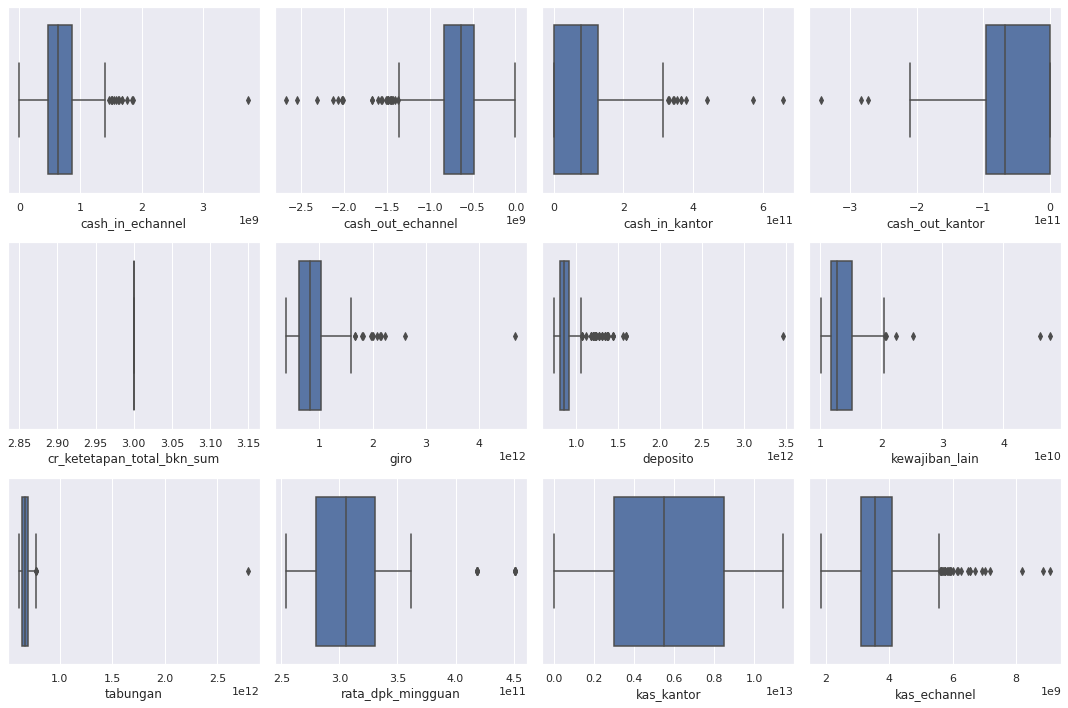

In [8]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(train.iloc[:,1:].columns.values):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x=col, data=train)
    plt.tight_layout()
plt.show()

Grafik boxplot di atas memperlihatkan bahwa perlunya _handling outliers_ di beberapa variable yaitu `giro`, `deposito`, `kewajiban_lain`, dan `tabungan` atau (juga termasuk variabel target).

#### Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.



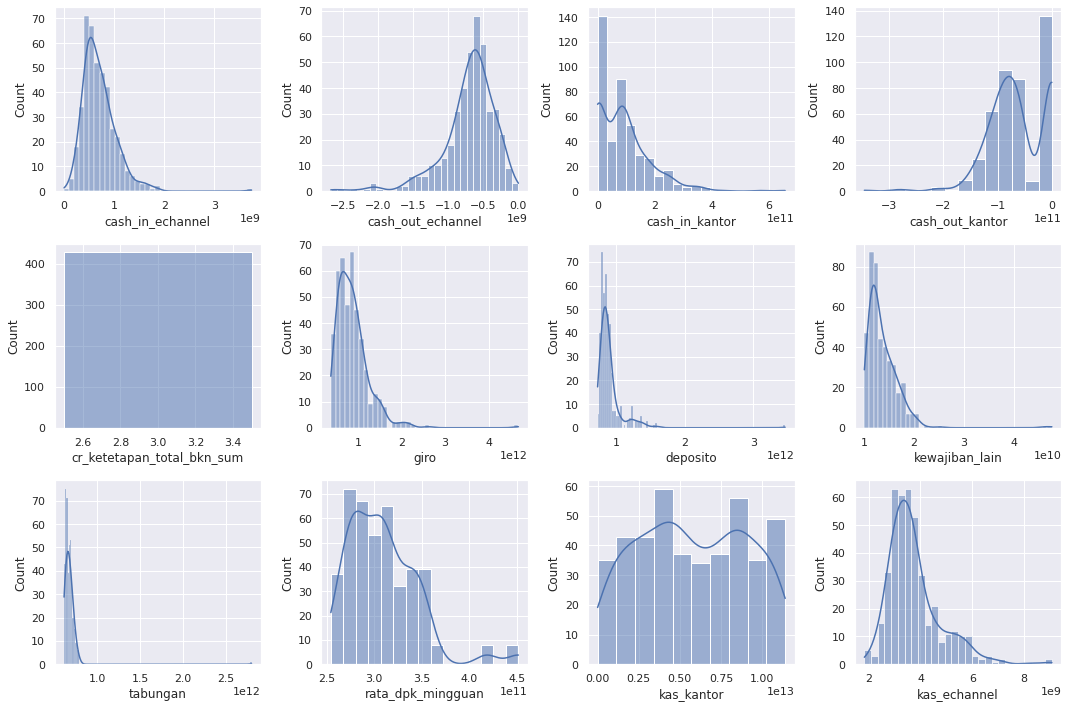

In [9]:
plt.figure(figsize=(15,10))
for idx, col in enumerate(train.iloc[:,1:].columns.values):
    plt.subplot(3, 4, idx+1)
    sns.histplot(data=train, x=col, kde=True)
    plt.tight_layout()
plt.show()

#### Correlation

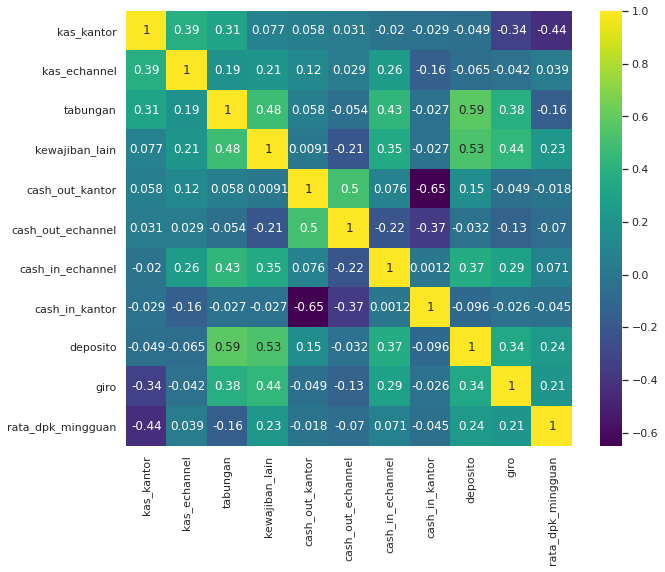

In [10]:
k = 12
cols = train.iloc[:,1:].corr().nlargest(k, 'kas_kantor')['kas_kantor'].index
cm = train[cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap = 'viridis')
plt.show()

### After Handle Outliers

#### Outliers

In [11]:
def replace_outliers(df, column, whisker_width=1.5):
    new_df = df.copy()
    for idx, cols in enumerate(column):
        Q1 = new_df[cols].quantile(0.25)
        Q3 = new_df[cols].quantile(0.75)
        IQR = Q3-Q1
        new_df[cols].replace(new_df[new_df[cols]<Q1-whisker_width*IQR][cols].tolist(), Q1, inplace=True)
        new_df[cols].replace(new_df[new_df[cols]>Q3+whisker_width*IQR][cols].tolist(), Q3, inplace=True)
    return new_df

In [12]:
train = replace_outliers(train, ['giro', 'deposito', 'kewajiban_lain', 'tabungan', 'rata_dpk_mingguan'])

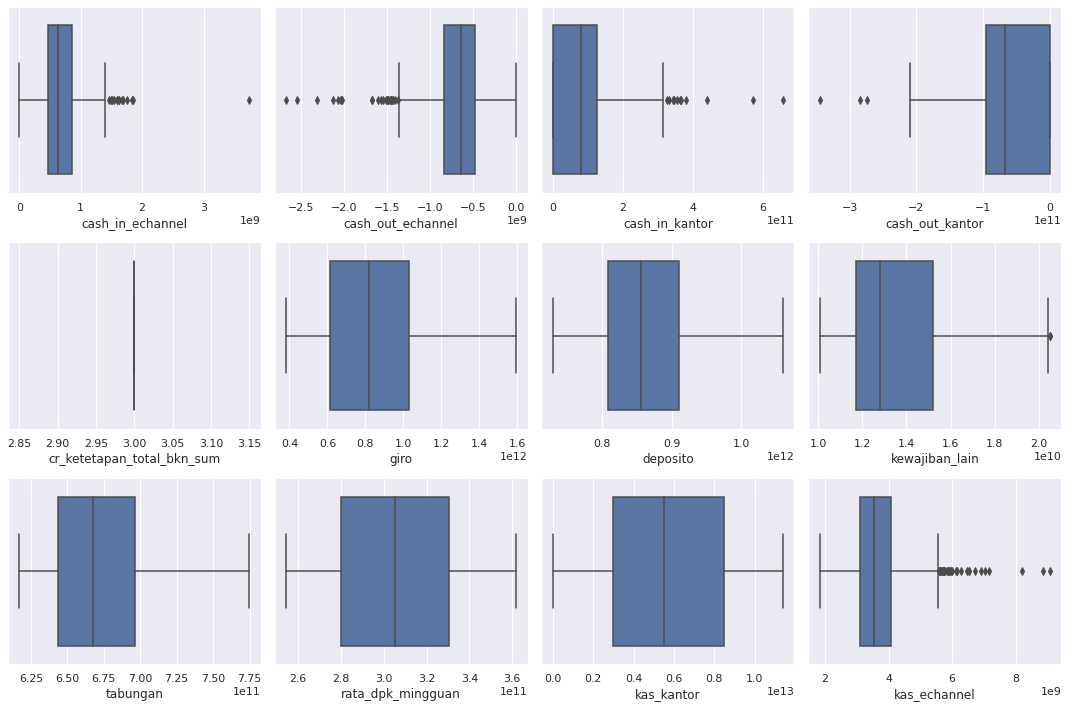

In [13]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(train.iloc[:,1:].columns.values):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x=col, data=train)
    plt.tight_layout()
plt.show()

#### Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.



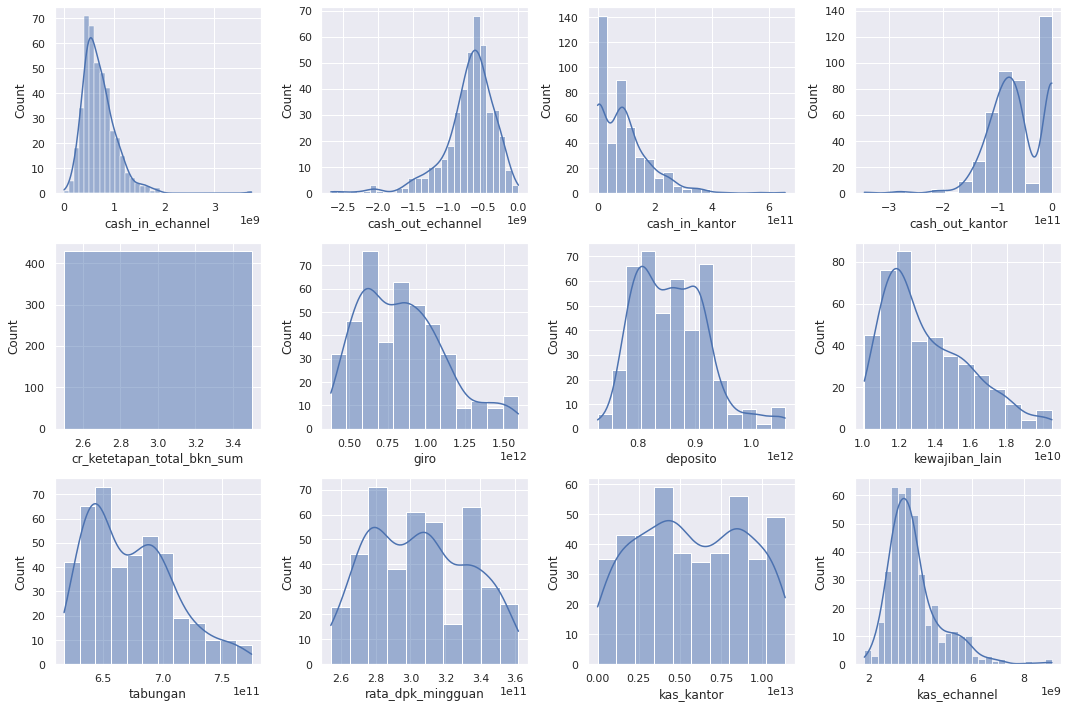

In [14]:
plt.figure(figsize=(15,10))
for idx, col in enumerate(train.iloc[:,1:].columns.values):
    plt.subplot(3, 4, idx+1)
    sns.histplot(data=train, x=col, kde=True)
    plt.tight_layout()
plt.show()

#### Correlation

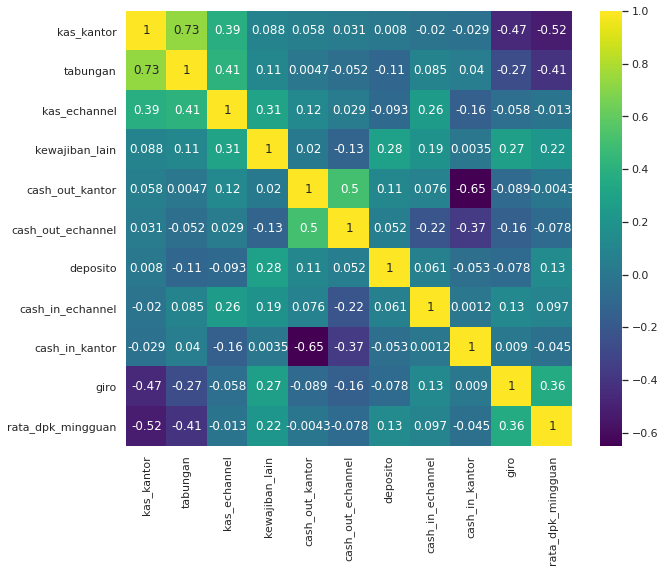

In [15]:
k = 12
cols = train.iloc[:,1:].corr().nlargest(k, 'kas_kantor')['kas_kantor'].index
cm = train[cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap = 'viridis')
plt.show()

## Exploratory Data Analysis

### Stationary

In [16]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults=True):
        adfTest = adfuller(timeseries, autolag='AIC')
        self.pValue = adfTest[1]
        
        if self.pValue < self.SignificanceLevel:
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[:4], index=['ADF Test Statistic', 'P-Value', 
                                                      '# Lags Used', '# Observations Used'])
            
        for key, value in adfTest[4].items():
            dfResults['Critical Value (%s)'%key] = value
        
        print('Augmented Dickey-Fuller Test Results:')
        print(dfResults)

In [17]:
sTest = StationarityTests()

#### e-Channel Stationary Check

In [18]:
cols_echannel = ['cash_in_echannel', 'cash_out_echannel']
for i in cols_echannel:
    print(f'Stationarity Test for {i}:')
    sTest.ADF_Stationarity_Test(train[i])
    print('Is the time series stationary? {0}'.format(sTest.isStationary))
    print('\n')

Stationarity Test for cash_in_echannel:
Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.704340
P-Value                   0.073290
# Lags Used              14.000000
# Observations Used     413.000000
Critical Value (1%)      -3.446283
Critical Value (5%)      -2.868564
Critical Value (10%)     -2.570511
dtype: float64
Is the time series stationary? False


Stationarity Test for cash_out_echannel:
Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.626227
P-Value                   0.005279
# Lags Used              13.000000
# Observations Used     414.000000
Critical Value (1%)      -3.446244
Critical Value (5%)      -2.868547
Critical Value (10%)     -2.570502
dtype: float64
Is the time series stationary? True




In [19]:
# Non-Stationary cash_in_echannel
train['cash_in_echannel_copy'] = train['cash_in_echannel']
train['cash_in_echannel_copy'] = train['cash_in_echannel_copy'] + 1
train['cash_in_echannel_copy'] = np.log(train['cash_in_echannel_copy'])

print(f'Stationarity Test for cash_in_echannel:')
sTest.ADF_Stationarity_Test(train['cash_in_echannel_copy'])
print('Is the time series stationary? {0}'.format(sTest.isStationary))

Stationarity Test for cash_in_echannel:
Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -19.534763
P-Value                   0.000000
# Lags Used               0.000000
# Observations Used     427.000000
Critical Value (1%)      -3.445758
Critical Value (5%)      -2.868333
Critical Value (10%)     -2.570388
dtype: float64
Is the time series stationary? True


#### Kantor Stationary Check

In [20]:
cols_kantor = ['cash_in_kantor', 'cash_out_kantor']
for i in cols_kantor:
    print(f'Stationarity Test for {i}:')
    sTest.ADF_Stationarity_Test(train[i])
    print('Is the time series stationary? {0}'.format(sTest.isStationary))
    print('\n')

Stationarity Test for cash_in_kantor:
Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -6.089585e+00
P-Value                 1.044271e-07
# Lags Used             1.800000e+01
# Observations Used     4.090000e+02
Critical Value (1%)    -3.446440e+00
Critical Value (5%)    -2.868633e+00
Critical Value (10%)   -2.570548e+00
dtype: float64
Is the time series stationary? True


Stationarity Test for cash_out_kantor:
Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.532157
P-Value                   0.000172
# Lags Used              13.000000
# Observations Used     414.000000
Critical Value (1%)      -3.446244
Critical Value (5%)      -2.868547
Critical Value (10%)     -2.570502
dtype: float64
Is the time series stationary? True




### Multivariate Analysis

In [21]:
cols = ['cash_in_echannel_copy', 'cash_out_echannel', 'cash_in_kantor', 'cash_out_kantor',
        'giro', 'deposito', 'kewajiban_lain', 'tabungan', 'rata_dpk_mingguan']

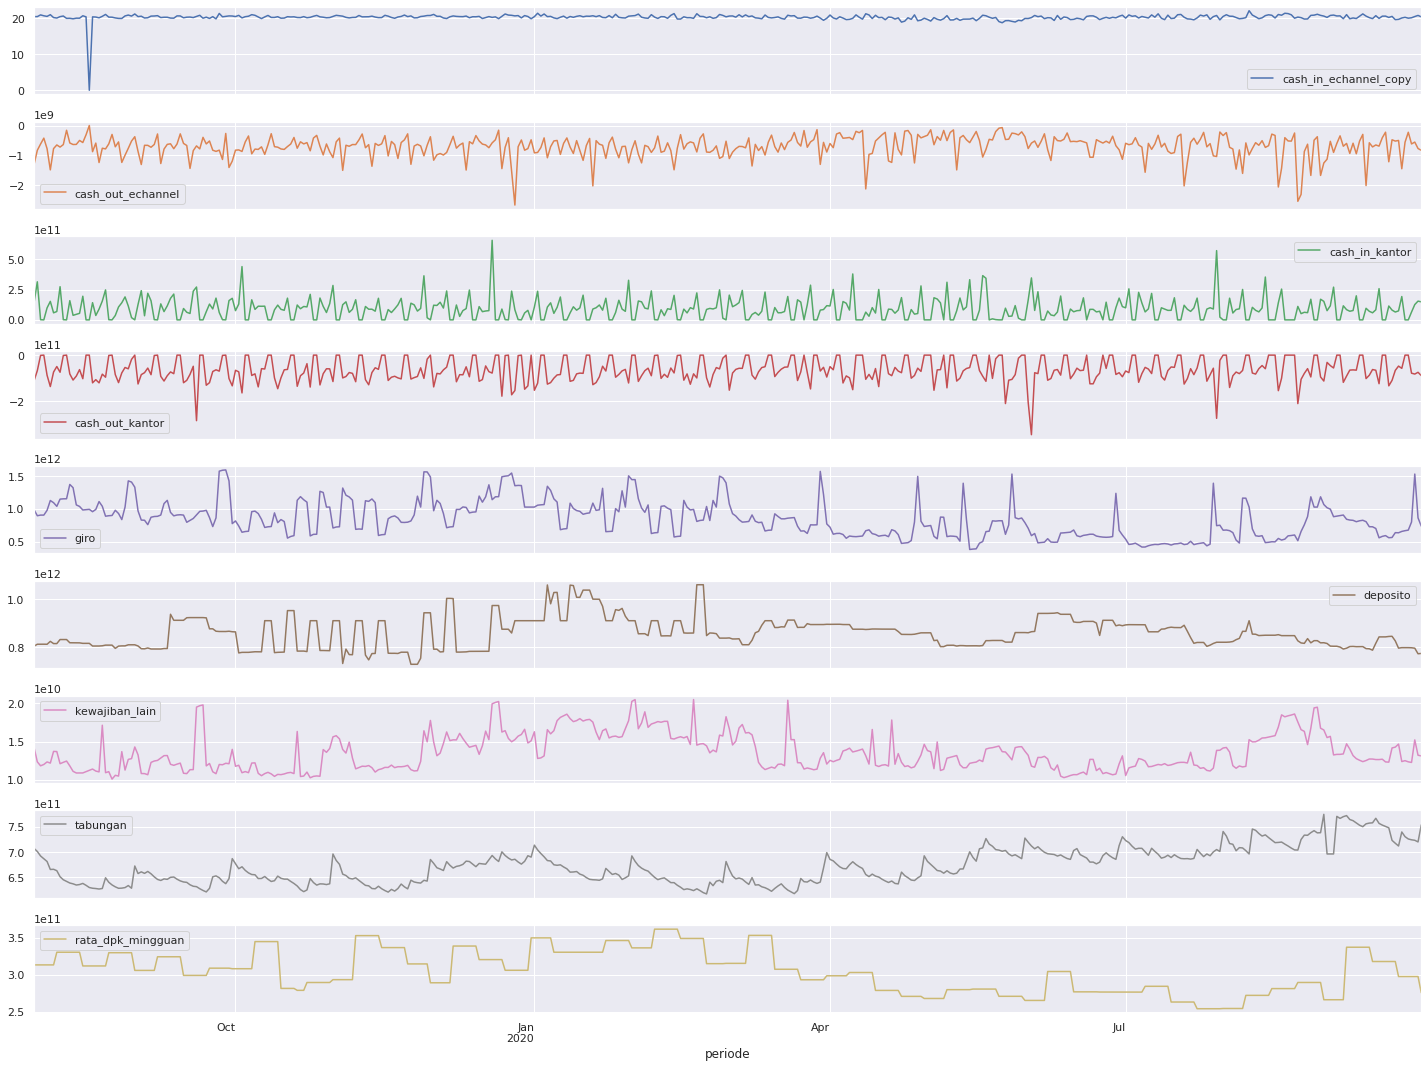

In [22]:
train.set_index('periode')[cols].plot(subplots=True, figsize=(20,15))
plt.xticks(rotation='horizontal')
plt.tight_layout()
plt.show()

Berdasarkan masing-masing data _time series_ di atas, tidak ada variabel yang memiliki hubungan kuat dengan variabel targetnya. Sehingga kita tidak akan melakukan proses prediksi dengan variabel lainnya.

## Modelling

### Holidays

In [23]:
ds = pd.Series(pd.to_datetime(['2019-12-24', '2019-12-25', '2020-01-01', '2020-03-25', '2020-04-10', '2020-05-01',
                               '2020-05-07', '2020-05-21', '2020-05-25', '2020-06-01', '2020-08-17', '2020-08-20',
                               '2020-08-21', '2020-10-28', '2020-10-30']))
day = pd.Series(['Cuti Bersama', 'Christmas', 'Tahun Baru Masehi', 'Nyepi', 'Jumat Agung', 'Hari Buruh', 'Waisak',
                 'Kenaikan Yesus Kristus', 'Idul Fitri', 'Hari Pancasila', 'Kemerdekaan RI', 'Tahun Baru Hijriyah',
                 'Cuti Bersama', 'Cuti Bersama', 'Cuti Bersama'])

In [24]:
holiday = pd.DataFrame({'holiday':day, 'ds':ds, 'lower_window':-1, 'upper_window':0})

### Cash in Kantor

In [25]:
cash_in_kantor = train[['periode', 'cash_in_kantor']].rename(
    columns={'periode':'ds', 'cash_in_kantor':'y'}
)
cash_in_kantor_copy = cash_in_kantor.copy()
cash_in_kantor_copy['y'] = cash_in_kantor_copy['y'] + 1
cash_in_kantor_copy['y'] = np.log(cash_in_kantor_copy['y'])
cash_in_kantor_copy.head()

ds          y
0 2019-07-31  25.690800
1 2019-08-01  26.473974
2 2019-08-02  20.947444
3 2019-08-03   0.000000
4 2019-08-04  25.316701

In [26]:
plot_result = cash_in_kantor.set_index('ds')
fig = go.Figure(data=go.Scatter(x=plot_result.index, y=plot_result['y']))
fig.show()

Insight :
1. Pada umumnya hari Kamis merupakan `cash_in_kantor` dengan angka tertinggi sementara Jum'at dan Sabtu merupakan angka terendah.
2. Akhir tahun terhitung lebih banyak hari dengan `cash_in_kantor` terendah dibandingkan minggu lainnya. Hal ini kemungkinan besar disebabkan oleh periode libur panjang Natal dan Tahun Baru.
3. Sejalan dengan poin nomor 2, pada akhir Mei juga terdapat pola yang kurang lebih sama disebabkan oleh periode Hari Raya Lebaran.
4. Kemungkinan besar jika terdapat periode long weekend maka akan terjadi penurunan drastis pada `cash_in_kantor`.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


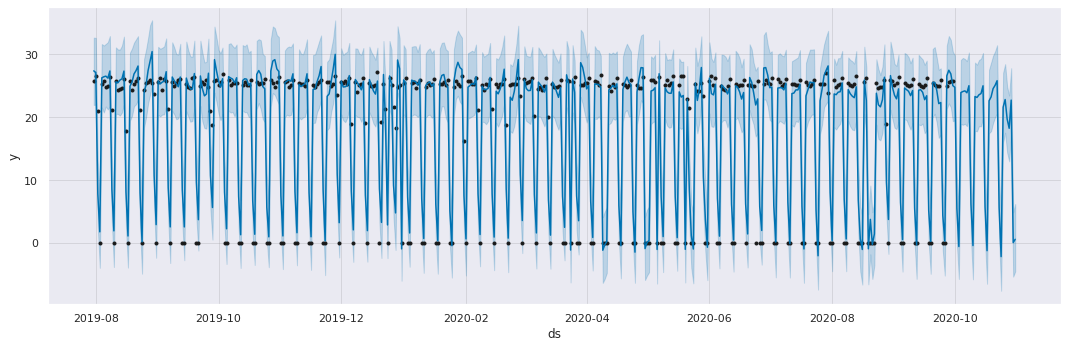

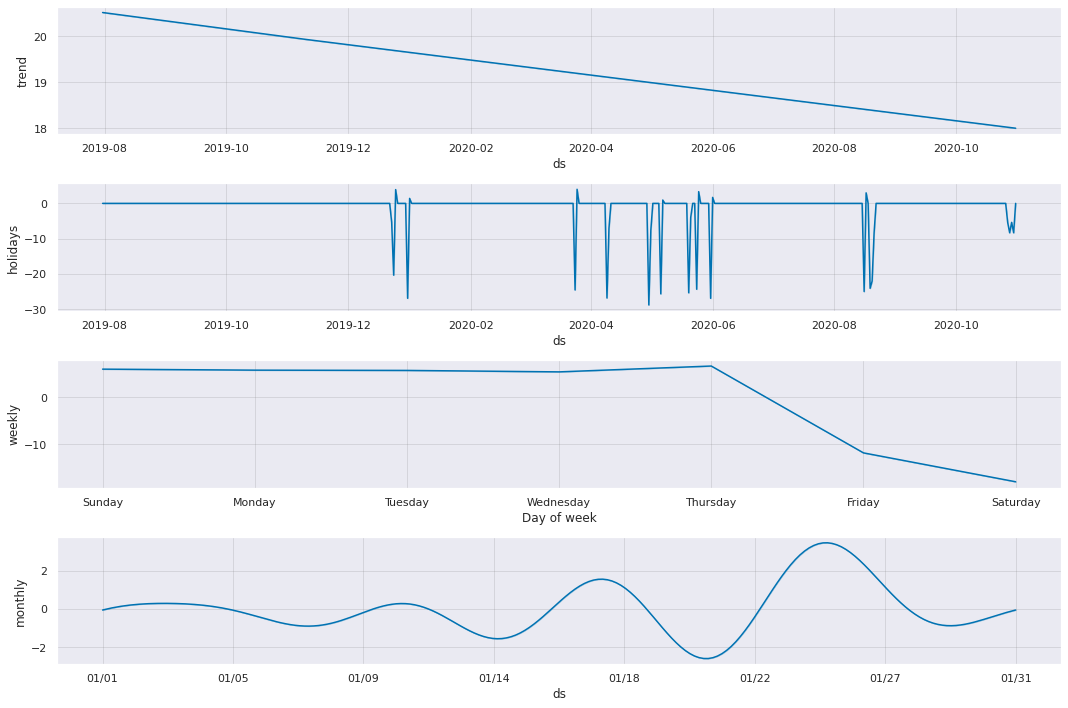

In [27]:
# Fitting model
model_in_kantor = Prophet(holidays=holiday)
model_in_kantor.add_seasonality('monthly', 30.5, 5)
model_in_kantor.fit(cash_in_kantor_copy)

# Forecasting
model_in_kantor31 = model_in_kantor.make_future_dataframe(periods=31, freq='D')
forecast_in_kantor31 = model_in_kantor.predict(model_in_kantor31)

# Visualize
fig = model_in_kantor.plot(forecast_in_kantor31, figsize=(15, 5))
fig = model_in_kantor.plot_components(forecast_in_kantor31, figsize=(15,10))
fig.show()

Insight :
1. `cash_in_kantor` memiliki trend yang terus menurun dari tahun 2019 hingga 2020.
2. Seasonality mingguan memperlihatkan bahwa puncak dari `cash_in_kantor` ada pada hari Kamis dan Jum'at - Sabtu merupakan hari terendah dibandingkan dengan hari lainnya.

In [28]:
# Hyperparameter tuning
from sklearn.metrics import mean_squared_log_error
from fbprophet.diagnostics import cross_validation
from tqdm import tqdm
import itertools

# Grid search parameters
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
    'holidays_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmsles = []

# Cross validation to evaluate all parameters
for params in tqdm(all_params):
  # Fitting model
  model_cash_in_kantor = Prophet(**params, holidays=holiday)
  model_cash_in_kantor.add_seasonality('monthly', 30.5, 5)
  model_cash_in_kantor.fit(cash_in_kantor_copy)

  # Expanding window cross validation
  cv = cross_validation(model_cash_in_kantor, initial='342 days', period='90 days', horizon='31 days')

  # Evaluation metrics: RMSLE
  rmsle = cv.groupby('cutoff').apply(lambda x: mean_squared_log_error(y_true=abs(x['y']), y_pred=abs(x['yhat']))**0.5)
  
  mean_rmsle = rmsle.mean()
  rmsles.append(mean_rmsle)

  0%|          | 0/50 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


  2%|▏         | 1/50 [00:02<01:49,  2.24s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


  4%|▍         | 2/50 [00:04<01:49,  2.27s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


  6%|▌         | 3/50 [00:06<01:46,  2.26s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


  8%|▊         | 4/50 [00:09<01:44,  2.26s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 10%|█         | 5/50 [00:11<01:38,  2.19s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 12%|█▏        | 6/50 [00:13<01:37,  2.22s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 14%|█▍        | 7/50 [00:15<01:34,  2.21s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 16%|█▌        | 8/50 [00:17<01:33,  2.22s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 18%|█▊        | 9/50 [00:19<01:29,  2.18s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 20%|██        | 10/50 [00:22<01:28,  2.20s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 22%|██▏       | 11/50 [00:24<01:24,  2.17s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 24%|██▍       | 12/50 [00:26<01:21,  2.15s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 26%|██▌       | 13/50 [00:28<01:21,  2.20s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 28%|██▊       | 14/50 [00:30<01:17,  2.16s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 30%|███       | 15/50 [00:33<01:18,  2.24s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 32%|███▏      | 16/50 [00:35<01:14,  2.19s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 34%|███▍      | 17/50 [00:37<01:13,  2.22s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 36%|███▌      | 18/50 [00:39<01:11,  2.23s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 38%|███▊      | 19/50 [00:41<01:08,  2.22s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 40%|████      | 20/50 [00:44<01:09,  2.32s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 42%|████▏     | 21/50 [00:46<01:05,  2.28s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 44%|████▍     | 22/50 [00:48<01:03,  2.27s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 46%|████▌     | 23/50 [00:51<01:01,  2.27s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 48%|████▊     | 24/50 [00:53<00:58,  2.25s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 50%|█████     | 25/50 [00:55<00:58,  2.32s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 52%|█████▏    | 26/50 [00:58<00:54,  2.28s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 54%|█████▍    | 27/50 [01:00<00:51,  2.25s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 56%|█████▌    | 28/50 [01:02<00:49,  2.24s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 58%|█████▊    | 29/50 [01:04<00:47,  2.26s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 60%|██████    | 30/50 [01:07<00:45,  2.25s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 62%|██████▏   | 31/50 [01:09<00:42,  2.21s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 64%|██████▍   | 32/50 [01:11<00:39,  2.19s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 66%|██████▌   | 33/50 [01:13<00:37,  2.20s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 68%|██████▊   | 34/50 [01:15<00:35,  2.25s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 70%|███████   | 35/50 [01:18<00:34,  2.28s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 72%|███████▏  | 36/50 [01:20<00:30,  2.18s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 74%|███████▍  | 37/50 [01:22<00:28,  2.20s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 76%|███████▌  | 38/50 [01:24<00:26,  2.22s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 78%|███████▊  | 39/50 [01:27<00:24,  2.25s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 80%|████████  | 40/50 [01:29<00:22,  2.26s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 82%|████████▏ | 41/50 [01:31<00:19,  2.19s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 84%|████████▍ | 42/50 [01:33<00:17,  2.16s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 86%|████████▌ | 43/50 [01:35<00:15,  2.23s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 88%|████████▊ | 44/50 [01:38<00:13,  2.22s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 90%|█████████ | 45/50 [01:40<00:11,  2.22s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 92%|█████████▏| 46/50 [01:42<00:08,  2.22s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 94%|█████████▍| 47/50 [01:44<00:06,  2.22s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 96%|█████████▌| 48/50 [01:46<00:04,  2.21s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 98%|█████████▊| 49/50 [01:49<00:02,  2.23s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


100%|██████████| 50/50 [01:51<00:00,  2.23s/it]

In [29]:
tuning_results_in_kantor = pd.DataFrame(all_params)
tuning_results_in_kantor['rmsle'] = rmsles
tuning_results_in_kantor.sort_values(by='rmsle').head()

seasonality_mode  changepoint_prior_scale  holidays_prior_scale     rmsle
10         additive                      0.3                   0.1  0.671481
5          additive                      0.2                   0.1  0.673136
0          additive                      0.1                   0.1  0.675535
11         additive                      0.3                   0.2  0.679982
12         additive                      0.3                   0.3  0.680463

In [30]:
# Result of tunning
# Fitting model
model_in_kantor = Prophet(seasonality_mode='additive', changepoint_prior_scale=0.5,
                          holidays_prior_scale=0.1, holidays=holiday)
model_in_kantor.add_seasonality('monthly', 30.5, 5)
model_in_kantor.fit(cash_in_kantor_copy)

# Forecasting
model_in_kantor31 = model_in_kantor.make_future_dataframe(periods=31, freq='D')
forecast_in_kantor31 = model_in_kantor.predict(model_in_kantor31)

# RMSLE
mean_squared_log_error(abs(cash_in_kantor['y']), abs(np.exp(forecast_in_kantor31[forecast_in_kantor31['ds']<='2020-09-30']['yhat']-1)))**0.5

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5.207356623466301

In [31]:
forecast_in_kantor31['yhat'] = np.exp(forecast_in_kantor31['yhat']) - 1
predict_in_kantor = pd.DataFrame(forecast_in_kantor31[['ds', 'yhat']][-31:])
predict_in_kantor.reset_index(drop=True, inplace=True)
predict_in_kantor.head()

ds          yhat
0 2020-10-01  1.115236e+10
1 2020-10-02  2.309724e+02
2 2020-10-03  3.762360e-01
3 2020-10-04  2.480747e+10
4 2020-10-05  6.073015e+10

### Cash Out Kantor

In [32]:
cash_out_kantor = train[['periode', 'cash_out_kantor']].rename(
    columns={'periode':'ds', 'cash_out_kantor':'y'}
)
cash_out_kantor.head()

ds             y
0 2019-07-31 -1.106104e+11
1 2019-08-01 -6.710987e+10
2 2019-08-02 -1.142332e+09
3 2019-08-03  0.000000e+00
4 2019-08-04 -8.729274e+10

In [33]:
plot_result = cash_out_kantor.set_index('ds')
fig = go.Figure(data=go.Scatter(x=plot_result.index, y=plot_result['y']))
fig.show()

Insight :
1. `cash_out_kantor` dengan pengeluaran paling sedikit seringnya terdapat di hari Jum'at dan Sabtu.
2. Kuantitas hari dengan pengeluaran lebih sedikit paling banyak terjadi di bulan Desember. Hal ini kemungkinan disebabkan oleh libur panjang natal dan tahun baru.
3. Kenapa ada hari tertentu yang non-holiday tapi pengeluaran tidak ada? Example: 24 Maret (sehari sebelum 25 Maret: Nyepi), 9 April (sehari sebelum 10 April: Jum'at Agung), 30 April (sehari sebelum 1 Mei: Hari Buruh), 6 Mei (sehari sebelum 7 Mei: Hari Raya Waisak), 20 Mei (sehari sebelum 21 Mei: Kenaikan Isa Almasih), dan lain-lain.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


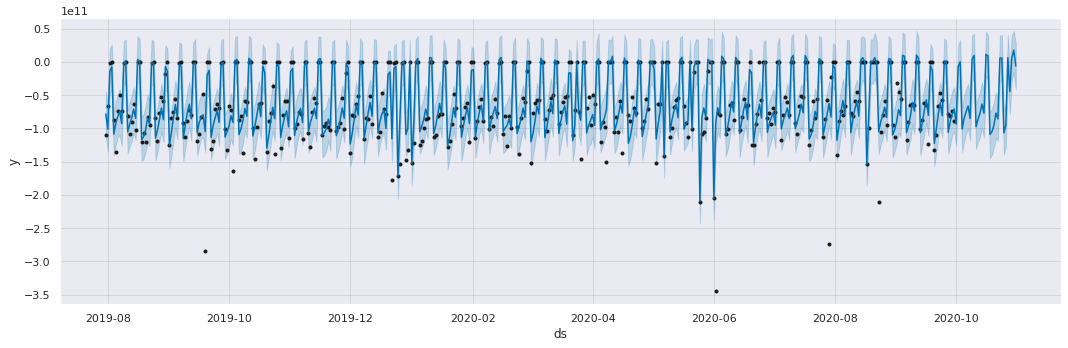

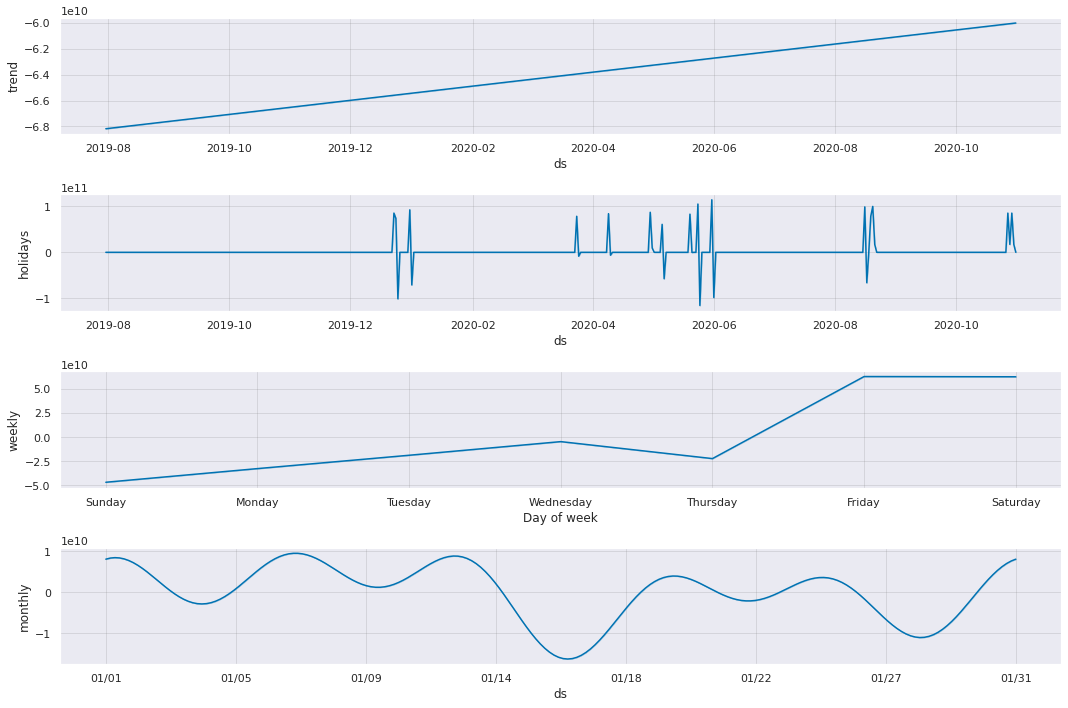

In [34]:
# Fitting model
model_out_kantor = Prophet(holidays=holiday)
model_out_kantor.add_seasonality('monthly', 30.5, 5)
model_out_kantor.fit(cash_out_kantor)

# Forecasting
model_out_kantor31 = model_out_kantor.make_future_dataframe(periods=31, freq='D')
forecast_out_kantor31 = model_out_kantor.predict(model_out_kantor31)

# Visualize
fig = model_out_kantor.plot(forecast_out_kantor31, figsize=(15, 5))
fig = model_out_kantor.plot_components(forecast_out_kantor31, figsize=(15, 10))
fig.show()

Insight :
1. Trend memperlihatkan bahwa `cash_out_kantor` terus mengalami peningkatan dari waktu ke waktu.
2. Berdasarkan grafik seasonality mingguan, Jum'at dan Sabtu merupakan hari dengan pengeluaran yang lebih sedikit.

In [35]:
# Hyperparameter tuning
# Grid search parameters
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
    'holidays_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmsles = []

# Cross validation to evaluate all parameters
for params in tqdm(all_params):
  # Fitting model
  model_cash_out_kantor = Prophet(**params, holidays=holiday)
  model_cash_out_kantor.add_seasonality('monthly', 30.5, 5)
  model_cash_out_kantor.fit(cash_out_kantor)

  # Expanding window cross validation
  cv = cross_validation(model_cash_out_kantor, initial='342 days', period='90 days', horizon='31 days')

  # Evaluation metrics: RMSLE
  rmsle = cv.groupby('cutoff').apply(lambda x: mean_squared_log_error(y_true=abs(x['y']), y_pred=abs(x['yhat']))**0.5)
  
  mean_rmsle = rmsle.mean()
  rmsles.append(mean_rmsle)

  0%|          | 0/50 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


  2%|▏         | 1/50 [00:02<01:45,  2.15s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


  4%|▍         | 2/50 [00:04<01:43,  2.15s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


  6%|▌         | 3/50 [00:06<01:42,  2.18s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


  8%|▊         | 4/50 [00:08<01:40,  2.19s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 10%|█         | 5/50 [00:10<01:36,  2.15s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 12%|█▏        | 6/50 [00:12<01:34,  2.15s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 14%|█▍        | 7/50 [00:15<01:33,  2.18s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 16%|█▌        | 8/50 [00:17<01:31,  2.19s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 18%|█▊        | 9/50 [00:19<01:29,  2.18s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 20%|██        | 10/50 [00:21<01:27,  2.19s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 22%|██▏       | 11/50 [00:23<01:25,  2.19s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 24%|██▍       | 12/50 [00:26<01:24,  2.22s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 26%|██▌       | 13/50 [00:28<01:23,  2.26s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 28%|██▊       | 14/50 [00:30<01:21,  2.27s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 30%|███       | 15/50 [00:33<01:19,  2.26s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 32%|███▏      | 16/50 [00:35<01:16,  2.24s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 34%|███▍      | 17/50 [00:37<01:13,  2.22s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 36%|███▌      | 18/50 [00:39<01:12,  2.26s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 38%|███▊      | 19/50 [00:42<01:09,  2.25s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 40%|████      | 20/50 [00:44<01:07,  2.26s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 42%|████▏     | 21/50 [00:46<01:05,  2.24s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 44%|████▍     | 22/50 [00:48<01:03,  2.27s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 46%|████▌     | 23/50 [00:51<01:00,  2.22s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 48%|████▊     | 24/50 [00:53<00:58,  2.25s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 50%|█████     | 25/50 [00:55<00:56,  2.27s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 52%|█████▏    | 26/50 [00:57<00:53,  2.25s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 54%|█████▍    | 27/50 [01:00<00:53,  2.33s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 56%|█████▌    | 28/50 [01:02<00:50,  2.30s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 58%|█████▊    | 29/50 [01:04<00:48,  2.32s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 60%|██████    | 30/50 [01:07<00:46,  2.33s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 62%|██████▏   | 31/50 [01:09<00:43,  2.31s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 64%|██████▍   | 32/50 [01:11<00:42,  2.34s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 66%|██████▌   | 33/50 [01:14<00:39,  2.30s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 68%|██████▊   | 34/50 [01:16<00:36,  2.26s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 70%|███████   | 35/50 [01:18<00:34,  2.33s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 72%|███████▏  | 36/50 [01:21<00:32,  2.32s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 74%|███████▍  | 37/50 [01:23<00:30,  2.33s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 76%|███████▌  | 38/50 [01:25<00:27,  2.30s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 78%|███████▊  | 39/50 [01:28<00:25,  2.33s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 80%|████████  | 40/50 [01:30<00:23,  2.35s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 82%|████████▏ | 41/50 [01:32<00:20,  2.31s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 84%|████████▍ | 42/50 [01:35<00:18,  2.37s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 86%|████████▌ | 43/50 [01:37<00:16,  2.36s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 88%|████████▊ | 44/50 [01:39<00:14,  2.35s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 90%|█████████ | 45/50 [01:42<00:11,  2.35s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 92%|█████████▏| 46/50 [01:44<00:09,  2.33s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 94%|█████████▍| 47/50 [01:47<00:07,  2.40s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 96%|█████████▌| 48/50 [01:49<00:04,  2.40s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 98%|█████████▊| 49/50 [01:51<00:02,  2.36s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


100%|██████████| 50/50 [01:54<00:00,  2.29s/it]

In [36]:
tuning_results_out_kantor = pd.DataFrame(all_params)
tuning_results_out_kantor['rmsle'] = rmsles
tuning_results_out_kantor.sort_values(by='rmsle').head()

seasonality_mode  changepoint_prior_scale  holidays_prior_scale      rmsle
23         additive                      0.5                   0.4  11.047991
24         additive                      0.5                   0.5  11.290246
48   multiplicative                      0.5                   0.4  11.300436
43   multiplicative                      0.4                   0.4  11.314741
47   multiplicative                      0.5                   0.3  11.315896

In [37]:
# Result of tunning
# Fitting model
model_out_kantor = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.5,
                           holidays_prior_scale=0.2, holidays=holiday)
model_out_kantor.add_seasonality('montly', 30.5, 5)
model_out_kantor.fit(cash_out_kantor)

# Forecasting
model_out_kantor31 = model_out_kantor.make_future_dataframe(periods=31, freq='D')
forecast_out_kantor31 = model_out_kantor.predict(model_out_kantor31)

# RMSLE
mean_squared_log_error(abs(cash_out_kantor['y']), abs(forecast_out_kantor31[forecast_out_kantor31['ds']<='2020-09-30']['yhat']))**0.5

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11.942438562467407

In [38]:
predict_out_kantor = pd.DataFrame(forecast_out_kantor31[['ds', 'yhat']][-31:])
predict_out_kantor.reset_index(drop=True, inplace=True)
predict_out_kantor.head()

ds          yhat
0 2020-10-01 -8.681745e+10
1 2020-10-02 -1.291005e+10
2 2020-10-03 -6.970341e+09
3 2020-10-04 -9.303999e+10
4 2020-10-05 -8.357262e+10

### Kas Kantor

In [39]:
last_kas_kantor = train.iloc[-1]['kas_kantor']
kas_kantor = []
for i in range(31):
  kas_kantor.append(last_kas_kantor + predict_in_kantor.iloc[i]['yhat'] + predict_out_kantor.iloc[i]['yhat'])
  last_kas_kantor = kas_kantor[-1]

In [40]:
kas_kantor = pd.Series(kas_kantor)
kas_kantor

0     1.133307e+13
1     1.132016e+13
2     1.131319e+13
3     1.124496e+13
4     1.122212e+13
5     1.117060e+13
6     1.111819e+13
7     1.107358e+13
8     1.107234e+13
9     1.107643e+13
10    1.099764e+13
11    1.093593e+13
12    1.088107e+13
13    1.084408e+13
14    1.084286e+13
15    1.084871e+13
16    1.085307e+13
17    1.075896e+13
18    1.067178e+13
19    1.060834e+13
20    1.057750e+13
21    1.056044e+13
22    1.056398e+13
23    1.056509e+13
24    1.046938e+13
25    1.040524e+13
26    1.035536e+13
27    1.031137e+13
28    1.027369e+13
29    1.028278e+13
30    1.027377e+13
dtype: float64

### Cash in e-Channel

In [41]:
cash_in_echannel = train[['periode', 'cash_in_echannel_copy']].rename(
    columns={'periode':'ds', 'cash_in_echannel_copy':'y'}
)
cash_in_echannel.head()

ds          y
0 2019-07-31  20.408966
1 2019-08-01  20.411564
2 2019-08-02  20.880099
3 2019-08-03  20.632739
4 2019-08-04  20.468696

In [42]:
plot_result = cash_in_echannel.set_index('ds')
fig = go.Figure(data=go.Scatter(x=plot_result.index, y=plot_result['y']))
fig.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


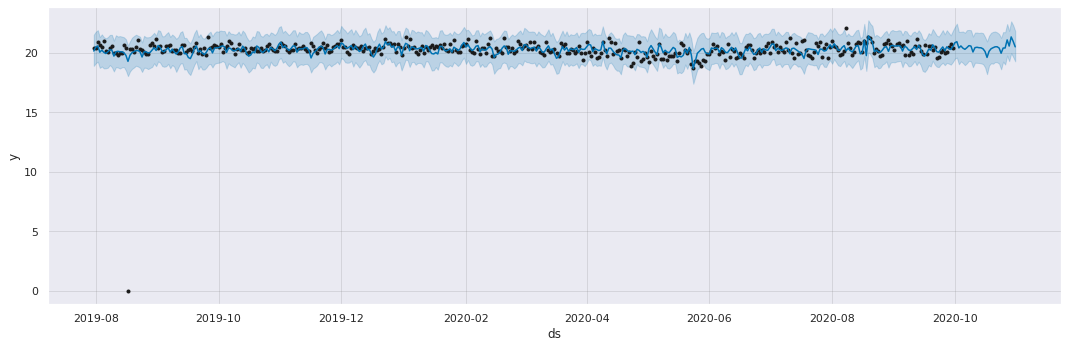

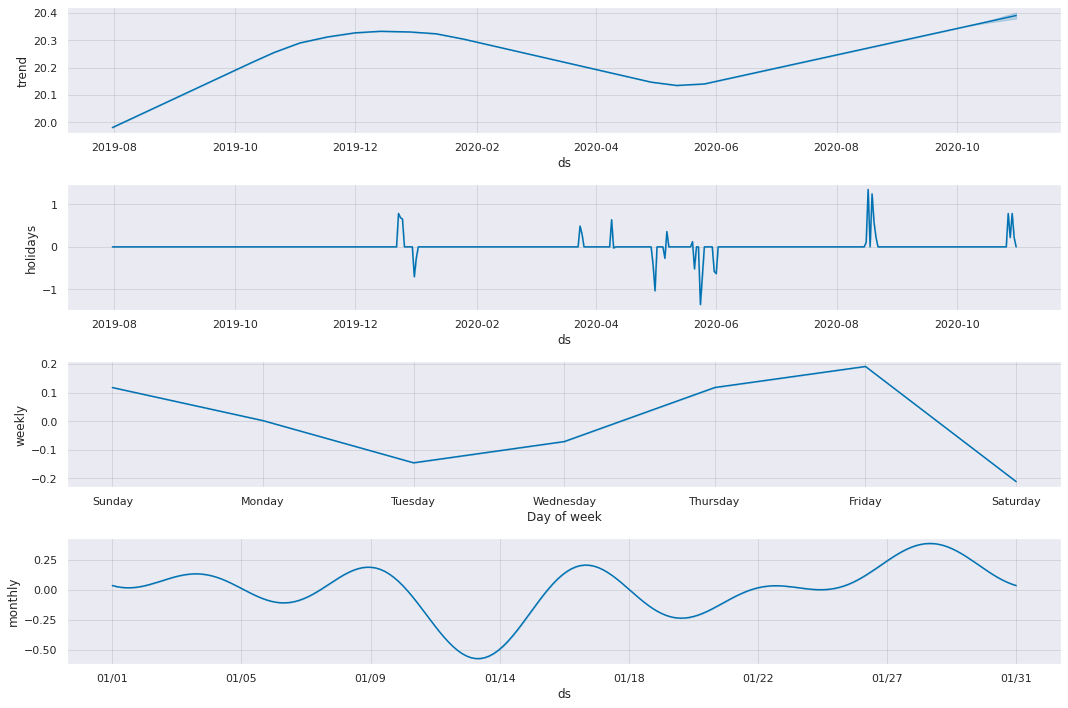

In [43]:
# Fitting model
model_in_echannel = Prophet(holidays=holiday)
model_in_echannel.add_seasonality('monthly', 30.5, 5)
model_in_echannel.fit(cash_in_echannel)

# Forecast
model_in_echannel31 = model_in_echannel.make_future_dataframe(periods=31, freq='D')
forecast_in_echannel31 = model_in_echannel.predict(model_in_echannel31)

# Visualize
fig = model_in_echannel.plot(forecast_in_echannel31, figsize=(15,5))
fig = model_in_echannel.plot_components(forecast_in_echannel31, figsize=(15,10))
fig.show()

Insight :
1. Terdapat perubahan trend pada `cash_in_echannel` dalam kurun waktu 2019 hingga 2020 dengan titik baliknya terdapat di kisaran bulan Mei.
2. Kamis - Sabtu merupakan peak day dari `cash_in_echannel`.

In [44]:
# Hyperparameter tuning
# Grid search parameters
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
    'holidays_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmsles = []

# Cross validation to evaluate all parameters
for params in tqdm(all_params):
  # Fitting model
  model_cash_in_echannel = Prophet(**params, holidays=holiday)
  model_cash_in_echannel.add_seasonality('monthly', 30.5, 5)
  model_cash_in_echannel.fit(cash_in_echannel)

  # Expanding window cross validation
  cv = cross_validation(model_cash_in_echannel, initial='342 days', period='90 days', horizon='31 days')

  # Evaluation metrics: RMSLE
  rmsle = cv.groupby('cutoff').apply(lambda x: mean_squared_log_error(y_true=abs(x['y']), y_pred=abs(x['yhat']))**0.5)
  
  mean_rmsle = rmsle.mean()
  rmsles.append(mean_rmsle)

  0%|          | 0/50 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


  2%|▏         | 1/50 [00:03<02:35,  3.18s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


  4%|▍         | 2/50 [00:05<02:21,  2.94s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


  6%|▌         | 3/50 [00:07<02:06,  2.70s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


  8%|▊         | 4/50 [00:09<01:56,  2.54s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 10%|█         | 5/50 [00:12<01:51,  2.48s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 12%|█▏        | 6/50 [00:14<01:45,  2.39s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 14%|█▍        | 7/50 [00:16<01:44,  2.43s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 16%|█▌        | 8/50 [00:19<01:39,  2.38s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 18%|█▊        | 9/50 [00:21<01:36,  2.36s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 20%|██        | 10/50 [00:23<01:33,  2.35s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 22%|██▏       | 11/50 [00:25<01:28,  2.28s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 24%|██▍       | 12/50 [00:28<01:27,  2.31s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 26%|██▌       | 13/50 [00:30<01:24,  2.30s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 28%|██▊       | 14/50 [00:32<01:23,  2.33s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 30%|███       | 15/50 [00:35<01:20,  2.31s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 32%|███▏      | 16/50 [00:37<01:20,  2.35s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 34%|███▍      | 17/50 [00:40<01:17,  2.36s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 36%|███▌      | 18/50 [00:42<01:14,  2.34s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 38%|███▊      | 19/50 [00:44<01:12,  2.35s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 40%|████      | 20/50 [00:47<01:10,  2.36s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 42%|████▏     | 21/50 [00:49<01:08,  2.37s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 44%|████▍     | 22/50 [00:52<01:09,  2.48s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 46%|████▌     | 23/50 [00:54<01:08,  2.53s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 48%|████▊     | 24/50 [00:57<01:05,  2.50s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 50%|█████     | 25/50 [00:59<01:02,  2.49s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 52%|█████▏    | 26/50 [01:02<00:57,  2.40s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 54%|█████▍    | 27/50 [01:04<00:55,  2.41s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 56%|█████▌    | 28/50 [01:06<00:51,  2.33s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 58%|█████▊    | 29/50 [01:08<00:48,  2.30s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 60%|██████    | 30/50 [01:11<00:45,  2.29s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 62%|██████▏   | 31/50 [01:13<00:42,  2.26s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 64%|██████▍   | 32/50 [01:15<00:42,  2.36s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 66%|██████▌   | 33/50 [01:18<00:40,  2.38s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 68%|██████▊   | 34/50 [01:20<00:37,  2.35s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 70%|███████   | 35/50 [01:22<00:35,  2.35s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 72%|███████▏  | 36/50 [01:25<00:32,  2.34s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 74%|███████▍  | 37/50 [01:27<00:30,  2.37s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 76%|███████▌  | 38/50 [01:29<00:27,  2.31s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 78%|███████▊  | 39/50 [01:32<00:25,  2.32s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 80%|████████  | 40/50 [01:34<00:23,  2.34s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 82%|████████▏ | 41/50 [01:36<00:20,  2.32s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 84%|████████▍ | 42/50 [01:39<00:18,  2.34s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 86%|████████▌ | 43/50 [01:41<00:16,  2.33s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 88%|████████▊ | 44/50 [01:43<00:14,  2.36s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 90%|█████████ | 45/50 [01:46<00:11,  2.37s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 92%|█████████▏| 46/50 [01:48<00:09,  2.35s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 94%|█████████▍| 47/50 [01:51<00:07,  2.46s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 96%|█████████▌| 48/50 [01:53<00:04,  2.43s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 98%|█████████▊| 49/50 [01:56<00:02,  2.44s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


100%|██████████| 50/50 [01:58<00:00,  2.37s/it]

In [45]:
tuning_results_in_echannel = pd.DataFrame(all_params)
tuning_results_in_echannel['rmsle'] = rmsles
tuning_results_in_echannel.sort_values(by='rmsle').head()

seasonality_mode  changepoint_prior_scale  holidays_prior_scale     rmsle
29   multiplicative                      0.1                   0.5  0.021813
4          additive                      0.1                   0.5  0.021904
28   multiplicative                      0.1                   0.4  0.021918
2          additive                      0.1                   0.3  0.021949
26   multiplicative                      0.1                   0.2  0.022034

In [46]:
# Result of tunning
# Fitting model
model_in_echannel = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.1,
                            holidays_prior_scale=0.3, holidays=holiday)
model_in_echannel.add_seasonality('monthly', 30.5, 5)
model_in_echannel.fit(cash_in_echannel)

# Forecast
model_in_echannel31 = model_in_echannel.make_future_dataframe(periods=31, freq='D')
forecast_in_echannel31 = model_in_echannel.predict(model_in_echannel31)

# RMSLE
mean_squared_log_error(abs(train['cash_in_echannel']), abs(np.exp(forecast_in_echannel31[forecast_in_echannel31['ds']<='2020-09-30']['yhat'])-1))**0.5

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1.024042469665808

In [47]:
forecast_in_echannel31['yhat'] = np.exp(forecast_in_echannel31['yhat']) - 1
predict_in_echannel = pd.DataFrame(forecast_in_echannel31[['ds', 'yhat']][-31:])
predict_in_echannel.reset_index(drop=True, inplace=True)
predict_in_echannel.head()

ds          yhat
0 2020-10-01  1.198054e+09
1 2020-10-02  1.325392e+09
2 2020-10-03  7.876736e+08
3 2020-10-04  9.282465e+08
4 2020-10-05  7.676811e+08

### Cash Out e-channel

In [48]:
cash_out_echannel = train[['periode', 'cash_out_echannel']].rename(
    columns={'periode':'ds', 'cash_out_echannel':'y'}
)
cash_out_echannel.head()

ds             y
0 2019-07-31 -1.304400e+09
1 2019-08-01 -8.321500e+08
2 2019-08-02 -6.214000e+08
3 2019-08-03 -4.240500e+08
4 2019-08-04 -7.779500e+08

In [49]:
plot_result = cash_out_echannel.set_index('ds')
fig = go.Figure(data=go.Scatter(x=plot_result.index, y=plot_result['y']))
fig.show()

Insight :
1. Sabtu adalah hari dengan jumlah `cash_out_echannel` yang paling sedikit ketimbang hari lainnya.
2. Gimana kalau POV-nya coba ngeliat yang di atas rataan sama di bawah rataan?

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


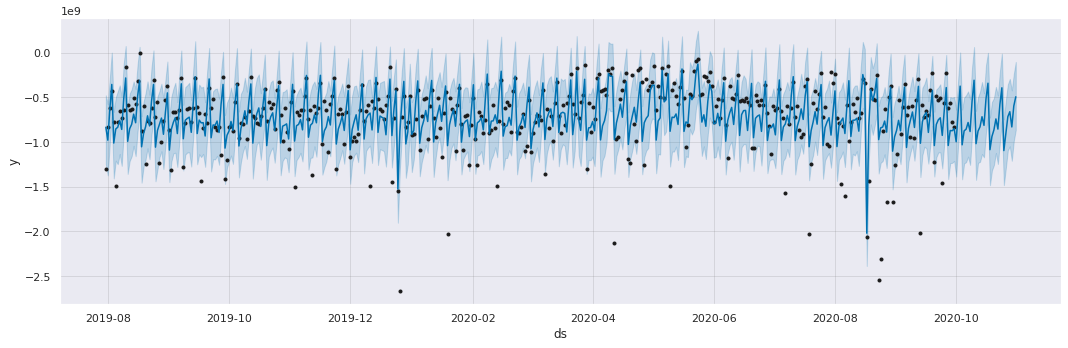

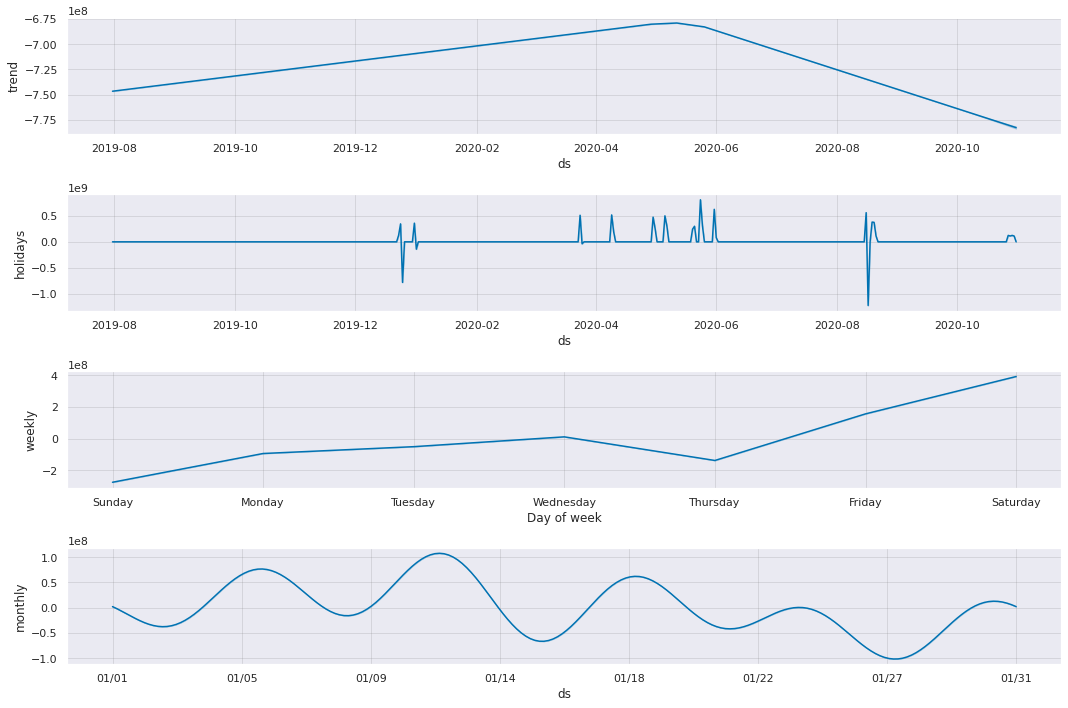

In [50]:
# Fitting model
model_out_echannel = Prophet(holidays=holiday)
model_out_echannel.add_seasonality('monthly', 30.5, 5)
model_out_echannel.fit(cash_out_echannel)

# Forecast
model_out_echannel31 = model_out_echannel.make_future_dataframe(periods=31, freq='D')
forecast_out_echannel31 = model_out_echannel.predict(model_out_echannel31)

# Visualize
fig = model_out_echannel.plot(forecast_out_echannel31, figsize=(15,5))
fig = model_out_echannel.plot_components(forecast_out_echannel31, figsize=(15,10))
fig.show()

Insight :
1. Sama halnya dengan trend dari `cash_in_echannel`, trend dari `cash_out_echannel` juga mengalami perubahan di kisaran bulan Mei.

In [51]:
# Hyperparameter tuning
# Grid search parameters
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5],
    'holidays_prior_scale': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmsles = []

# Cross validation to evaluate all parameters
for params in tqdm(all_params):
  # Fitting model
  model_cash_out_echannel = Prophet(**params, holidays=holiday)
  model_cash_out_echannel.add_seasonality('monthly', 30.5, 5)
  model_cash_out_echannel.fit(cash_out_echannel)

  # Expanding window cross validation
  cv = cross_validation(model_cash_out_echannel, initial='342 days', period='90 days', horizon='31 days')

  # Evaluation metrics: RMSLE
  rmsle = cv.groupby('cutoff').apply(lambda x: mean_squared_log_error(y_true=abs(x['y']), y_pred=abs(x['yhat']))**0.5)
  
  mean_rmsle = rmsle.mean()
  rmsles.append(mean_rmsle)

  0%|          | 0/50 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


  2%|▏         | 1/50 [00:02<01:51,  2.28s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


  4%|▍         | 2/50 [00:04<01:46,  2.22s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


  6%|▌         | 3/50 [00:06<01:45,  2.25s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


  8%|▊         | 4/50 [00:09<01:46,  2.31s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 10%|█         | 5/50 [00:11<01:42,  2.29s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 12%|█▏        | 6/50 [00:13<01:39,  2.27s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 14%|█▍        | 7/50 [00:15<01:36,  2.25s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 16%|█▌        | 8/50 [00:17<01:33,  2.23s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 18%|█▊        | 9/50 [00:20<01:33,  2.27s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 20%|██        | 10/50 [00:22<01:27,  2.18s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 22%|██▏       | 11/50 [00:24<01:23,  2.14s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 24%|██▍       | 12/50 [00:26<01:22,  2.17s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 26%|██▌       | 13/50 [00:28<01:20,  2.19s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 28%|██▊       | 14/50 [00:31<01:18,  2.19s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 30%|███       | 15/50 [00:33<01:17,  2.22s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 32%|███▏      | 16/50 [00:35<01:14,  2.21s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 34%|███▍      | 17/50 [00:37<01:12,  2.21s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 36%|███▌      | 18/50 [00:40<01:11,  2.24s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 38%|███▊      | 19/50 [00:42<01:11,  2.31s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 40%|████      | 20/50 [00:44<01:09,  2.30s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 42%|████▏     | 21/50 [00:46<01:05,  2.27s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 44%|████▍     | 22/50 [00:49<01:03,  2.26s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 46%|████▌     | 23/50 [00:51<01:00,  2.24s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 48%|████▊     | 24/50 [00:53<00:58,  2.23s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 50%|█████     | 25/50 [00:55<00:56,  2.26s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 52%|█████▏    | 26/50 [00:58<00:54,  2.25s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 54%|█████▍    | 27/50 [01:00<00:51,  2.23s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 56%|█████▌    | 28/50 [01:02<00:50,  2.28s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 58%|█████▊    | 29/50 [01:04<00:47,  2.26s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 60%|██████    | 30/50 [01:07<00:45,  2.28s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 62%|██████▏   | 31/50 [01:09<00:43,  2.27s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 64%|██████▍   | 32/50 [01:11<00:40,  2.24s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 66%|██████▌   | 33/50 [01:14<00:39,  2.30s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 68%|██████▊   | 34/50 [01:16<00:36,  2.28s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 70%|███████   | 35/50 [01:18<00:34,  2.28s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 72%|███████▏  | 36/50 [01:20<00:31,  2.26s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 74%|███████▍  | 37/50 [01:23<00:29,  2.24s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 76%|███████▌  | 38/50 [01:25<00:28,  2.34s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 78%|███████▊  | 39/50 [01:27<00:25,  2.35s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 80%|████████  | 40/50 [01:30<00:22,  2.29s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 82%|████████▏ | 41/50 [01:32<00:20,  2.31s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 84%|████████▍ | 42/50 [01:34<00:18,  2.29s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 86%|████████▌ | 43/50 [01:36<00:15,  2.27s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 88%|████████▊ | 44/50 [01:39<00:14,  2.35s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 90%|█████████ | 45/50 [01:41<00:11,  2.32s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 92%|█████████▏| 46/50 [01:44<00:09,  2.31s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 94%|█████████▍| 47/50 [01:46<00:07,  2.36s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 96%|█████████▌| 48/50 [01:48<00:04,  2.37s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


 98%|█████████▊| 49/50 [01:51<00:02,  2.36s/it]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-08-30 00:00:00 and 2020-08-30 00:00:00


100%|██████████| 50/50 [01:53<00:00,  2.27s/it]

In [52]:
tuning_results_out_echannel = pd.DataFrame(all_params)
tuning_results_out_echannel['rmsle'] = rmsles
tuning_results_out_echannel.sort_values(by='rmsle').head()

seasonality_mode  changepoint_prior_scale  holidays_prior_scale     rmsle
25   multiplicative                      0.1                   0.1  0.527508
4          additive                      0.1                   0.5  0.527693
3          additive                      0.1                   0.4  0.529754
2          additive                      0.1                   0.3  0.533272
1          additive                      0.1                   0.2  0.533427

In [53]:
# Result of tunning
# Fitting model
model_out_echannel = Prophet(seasonality_mode='additive', changepoint_prior_scale=0.1,
                             holidays_prior_scale=0.1, holidays=holiday)
model_out_echannel.add_seasonality('monthly', 30.5, 5)
model_out_echannel.fit(cash_out_echannel)

# Forecast
model_out_echannel31 = model_out_echannel.make_future_dataframe(periods=31, freq='D')
forecast_out_echannel31 = model_out_echannel.predict(model_out_echannel31)

# RMSLE
mean_squared_log_error(abs(cash_out_echannel['y']), abs(forecast_out_echannel31[forecast_out_echannel31['ds']<='2020-09-30']['yhat']))**0.5

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1.0192788307455471

In [54]:
predict_out_echannel = pd.DataFrame(forecast_out_echannel31[['ds', 'yhat']][-31:])
predict_out_echannel.reset_index(drop=True, inplace=True)
predict_out_echannel.head()

ds          yhat
0 2020-10-01 -1.026438e+09
1 2020-10-02 -7.144821e+08
2 2020-10-03 -4.473097e+08
3 2020-10-04 -1.085244e+09
4 2020-10-05 -9.467240e+08

### Kas Echannel

In [55]:
last_kas_echannel = train.iloc[-1]['kas_echannel']
kas_echannel = []
for i in range(31):
  kas_echannel.append(last_kas_echannel + predict_in_echannel.iloc[i]['yhat'] + predict_out_echannel.iloc[i]['yhat'])
  last_kas_echannel = kas_echannel[-1]

In [56]:
kas_echannel = pd.Series(kas_echannel)
kas_echannel

0     5.443515e+09
1     6.054426e+09
2     6.394789e+09
3     6.237792e+09
4     6.058749e+09
5     5.847662e+09
6     5.813698e+09
7     5.838391e+09
8     6.150839e+09
9     6.331063e+09
10    6.064130e+09
11    5.939263e+09
12    5.849302e+09
13    5.858013e+09
14    5.711240e+09
15    5.698995e+09
16    5.628451e+09
17    5.076234e+09
18    4.792465e+09
19    4.672237e+09
20    4.733767e+09
21    4.700795e+09
22    4.843079e+09
23    4.885111e+09
24    4.510627e+09
25    4.295417e+09
26    5.228262e+09
27    5.427150e+09
28    6.772423e+09
29    7.526696e+09
30    7.849341e+09
dtype: float64

In [57]:
final_result = pd.concat([kas_kantor, kas_echannel], ignore_index=True).rename('value')
final_result.head()

0    1.133307e+13
1    1.132016e+13
2    1.131319e+13
3    1.124496e+13
4    1.122212e+13
Name: value, dtype: float64